In [1]:
from resources.notebook_library import *
from resources.gate_simulation.ghz import ghz_simulation
from resources.gate_simulation.ghz import gate_simulation_functions
GateSimulation  = reload(ghz_simulation)
sim = GateSimulation.Simulation('O-x-O')

Initializing system O-x-O ...
Constructing states and excitations ...
Constructing ground and first-excited statespace ...
Constructing gs_hamiltonian ...
Constructing e1_hamiltonian ...
Constructing interactions V_plus and V_minus ...
Constructing NJ_hamiltonian ...
Inverting NJ_hamiltonian ...


Error in atexit._run_exitfuncs:
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/IPython/core/history.py", line 576, in end_session
    self.db.execute("""UPDATE sessions SET end=?, num_cmds=? WHERE
sqlite3.OperationalError: disk I/O error


Constructing eff_hamiltonian and effective lindblad operators ...

System  O-x-O  initialized in 29.8 seconds.
Preparing Analytical sub-class

Done!


# Obtain grid(s) of performance

In [25]:
# Global Parameters 
kSweep = [0.99]   #[0.995]

CSweep =[50,75]#[25,50,75]#,50,75]

SplitSweep =[10,15]#[5,10,15]#,10,15,20]# [5,10]
 

# Bounds of optimization
## DE will be multiplied by  np.sqrt(C_val)/gamma_val
DE_min = 0.01 
DE_max = 4
tg_min = 0.8
tg_max = 1.2
rot_min = 0.8
rot_max = 1.2


# Optimization settings
opt_settings_dict = {
"ghz_dim":3,                # 3-ghz state or 4-ghz state
'swap_into_memory':False,    # Use of nuclear memory
'fidelity_cap': 0.97 , 'confidence_interval':0.99, #Cost function parameters
"n_cores": 16,  # Number of cores to use in optimization
"disp_bool" : False} # Show optimization progress

## Using analytical simulations

In [26]:
gamma_val = sim.parameters[sg.var('gamma')]

SplitSweep = [spl*gamma_val for spl in SplitSweep] # for gamma_val = 1 it is not necessary

AllParams = [(a,b,c) for a in kSweep for b in CSweep for c in SplitSweep] # Create a 3-d grid for hardware parameters

TotalParamElems = NumElemsInList(AllParams)


CurrentNumberOfSimulations = 1
Results = [ [{} for j in range(len(SplitSweep))] for i in range(len(CSweep))]
for  (k, C_val , max_split) in AllParams:
    print(f'Optimizing {CurrentNumberOfSimulations} out of {TotalParamElems}')
    CurrentNumberOfSimulations +=1
    c_val = k/ (4-4*k)
    
    hardware_dict = {'c': c_val,'k':k , 'C':C_val ,'max_split': max_split}

    sim.Analytical.obtain_gate_performance_hardware(hardware_dict)
    bounds = [[0 , max_split] , [0,DE_max*np.sqrt(C_val)/gamma_val ] , [tg_min,tg_max]  ]
    # Add rotation bounds depending on the ghz_dim
    for i in range(opt_settings_dict["ghz_dim"]) : bounds.append([rot_min,rot_max]) 

    sim.Analytical.optimize_gate_performance_hardware(bounds,opt_settings_dict)
    
    optimized_performance_dict = sim.Analytical.optimized_performance_dict
    opt_cost_function = gate_simulation_functions.gate_performance_cost_function(optimized_performance_dict,opt_settings_dict)

    tunable_params_dict = sim.Analytical.opt_tunable_dict
    
    result = {'hardware': hardware_dict , 
            'performance': optimized_performance_dict,
            'tuning': tunable_params_dict,
            'opt_settings' : opt_settings_dict, 
            'cost': opt_cost_function}
    i = np.where(C_val == np.array(CSweep) )[0][0]
    j = np.where(max_split == np.array(SplitSweep) )[0][0]
    Results[i][j] = result

    clear_output(wait=True)

Optimizing 1 out of 4


KeyboardInterrupt: 

# Print results

In [7]:
for i,C in enumerate(CSweep):
    for j,spl in enumerate(SplitSweep):
        pass
        #print(Results[i][j]['tuning'][sg.var('DE')]/np.sqrt(C))
        #print(Results[i][j]['tuning'][sg.var('De')],spl)
        print([Results[i][j]['tuning'][sg.var(f'r{k}_r')]  for k in range(opt_settings_dict["ghz_dim"] ) ])
       

[1.0530352240043162, 0.9244105477128866, 1.1719331017304215]
[0.8, 0.8, 0.8]
[1.048053152190235, 1.1260732657269, 0.9656219562293475]
[1.0465876904939282, 1.188003008482968, 0.9014153588010462]


In [8]:
costs = np.array([[Results[i][j]['cost'] for j in range(len(SplitSweep))]for i in range(len(CSweep))])
i_min, j_min = ArgMin(costs)

Results[i_min][j_min]

{'hardware': {'c': 24.74999999999998, 'k': 0.99, 'C': 75, 'max_split': 15},
 'performance': {'gate_time': 7.812493210812349,
  'p_success': 0.12088028309653803,
  'fidelity': 0.9700168398947872,
  't_conf': 0.0028335103458328086},
 'tuning': {De: 0.9178072095760683,
  DE: 3.269171693839194,
  tgr: 0.9142834068583361,
  r0_r: 1.0465876904939282,
  r1_r: 1.188003008482968,
  r2_r: 0.9014153588010462,
  tgs: 7.812493210812349,
  pss: 0.12088028309653803},
 'opt_settings': {'ghz_dim': 3,
  'swap_into_memory': False,
  'fidelity_cap': 0.97,
  'confidence_interval': 0.99,
  'n_cores': 16,
  'disp_bool': False},
 'cost': -349.9191278481413}

# Plot result

In [27]:
Analytical = True
kPlot = kSweep[0]
cPlot = kPlot / (4-4*kPlot)

fidelity_cap = 0.97
interval_of_confidence = 0.99



AllLabels = [["" for i in range(len(SplitSweep))]for j in range(len(CSweep))]
plotted_values = np.zeros(np.array(AllLabels).shape)
for (i,c) in enumerate(CSweep):
    for (j,spl) in enumerate(SplitSweep):
        
        res = Results[i][j]
        
        # Extreact parameters
        opt_tg = res['performance']['gate_time']
        opt_fid = res['performance']['fidelity']
        opt_p_success = res['performance']['p_success']
        fidelity , p_success, gate_time = opt_fid , opt_p_success , opt_tg
        t_conf = res['performance']['t_conf']
        min_cost_function = res['cost']      
        
        plotted_values[i][j] = min_cost_function       
        

        AllLabels[i][j] += '$F='+ str(np.round(fidelity*100,decimals=2))+'\%$\n'
        AllLabels[i][j] += '$P_{succ}='+ str(np.round(p_success*100,decimals=2))+'\%$\n'
        AllLabels[i][j] += '$t_g='+ str(quantiphy.Quantity(gate_time/experimental_values_dict['gamma']))+r's$'
        AllLabels[i][j] += '\n$t_{'+str(np.round(interval_of_confidence,decimals=2)) +'} = '+ str(quantiphy.Quantity(t_conf)) +r's$'
        AllLabels[i][j] += '\n$c_f='+ str( int( min_cost_function))+'$'
        


fig, ax = plt.subplots()


ax = sns.heatmap(plotted_values,yticklabels=CSweep,xticklabels=SplitSweep,cmap='gray_r', linewidth=0.5,annot=AllLabels, fmt = ''\
    ,cbar_kws={'label': 'Cost Function'}, annot_kws={"size": 14}) #Greys
ax.set_ylabel('Cooperativity')
ax.set_xlabel(r'Max Detuning Split $(\gamma)$')
ax.set_title(f'Gate Performance vs Cooperativity & Detuning Split \nfor $k={kPlot} \Leftrightarrow c = {np.round(cPlot,decimals=1)}$\n'
+r' $(\Delta_e,\Delta_E,t_g,rot)$ are optimized')
plt.show() 
figure = ax.get_figure()
figure.savefig(f'plots/OptimizedHeatmap.svg',transparent=False)

<>:28: DeprecationWarning: invalid escape sequence \%
<>:29: DeprecationWarning: invalid escape sequence \%
<>:43: DeprecationWarning: invalid escape sequence \L
<>:28: DeprecationWarning: invalid escape sequence \%
<>:29: DeprecationWarning: invalid escape sequence \%
<>:43: DeprecationWarning: invalid escape sequence \L
<ipython-input-27-02a36391f80b>:28: DeprecationWarning: invalid escape sequence \%
  AllLabels[i][j] += '$F='+ str(np.round(fidelity*100,decimals=2))+'\%$\n'
<ipython-input-27-02a36391f80b>:29: DeprecationWarning: invalid escape sequence \%
  AllLabels[i][j] += '$P_{succ}='+ str(np.round(p_success*100,decimals=2))+'\%$\n'
<ipython-input-27-02a36391f80b>:43: DeprecationWarning: invalid escape sequence \L
  ax.set_title(f'Gate Performance vs Cooperativity & Detuning Split \nfor $k={kPlot} \Leftrightarrow c = {np.round(cPlot,decimals=1)}$\n'


KeyError: 'performance'

# Tests

<>:28: DeprecationWarning: invalid escape sequence \%
<>:29: DeprecationWarning: invalid escape sequence \%
<>:43: DeprecationWarning: invalid escape sequence \L
<>:28: DeprecationWarning: invalid escape sequence \%
<>:29: DeprecationWarning: invalid escape sequence \%
<>:43: DeprecationWarning: invalid escape sequence \L
<ipython-input-12-02a36391f80b>:28: DeprecationWarning: invalid escape sequence \%
  AllLabels[i][j] += '$F='+ str(np.round(fidelity*100,decimals=2))+'\%$\n'
<ipython-input-12-02a36391f80b>:29: DeprecationWarning: invalid escape sequence \%
  AllLabels[i][j] += '$P_{succ}='+ str(np.round(p_success*100,decimals=2))+'\%$\n'
<ipython-input-12-02a36391f80b>:43: DeprecationWarning: invalid escape sequence \L
  ax.set_title(f'Gate Performance vs Cooperativity & Detuning Split \nfor $k={kPlot} \Leftrightarrow c = {np.round(cPlot,decimals=1)}$\n'


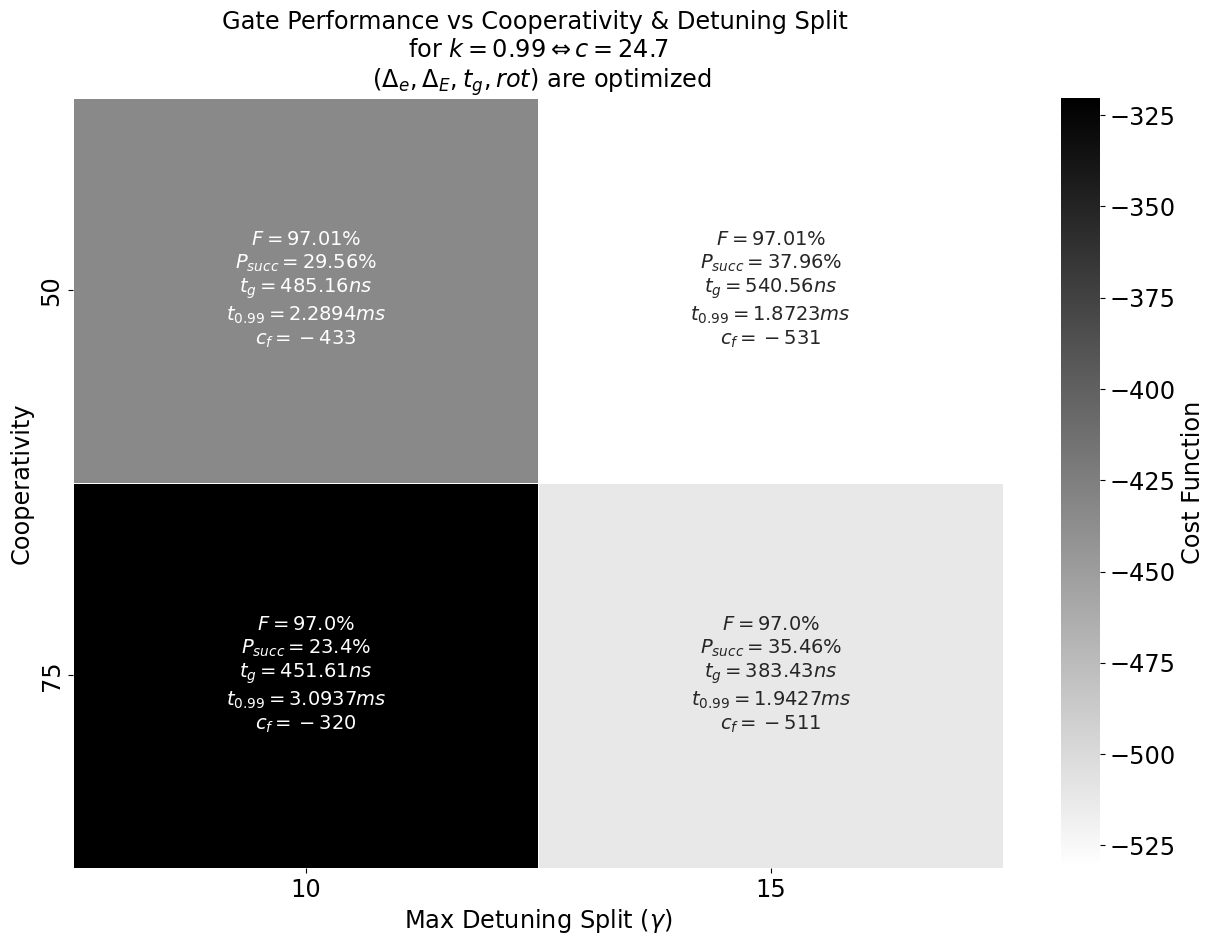

In [12]:
Analytical = True
kPlot = kSweep[0]
cPlot = kPlot / (4-4*kPlot)

fidelity_cap = 0.97
interval_of_confidence = 0.99



AllLabels = [["" for i in range(len(SplitSweep))]for j in range(len(CSweep))]
plotted_values = np.zeros(np.array(AllLabels).shape)
for (i,c) in enumerate(CSweep):
    for (j,spl) in enumerate(SplitSweep):
        
        res = Results[i][j]
        
        # Extreact parameters
        opt_tg = res['performance']['gate_time']
        opt_fid = res['performance']['fidelity']
        opt_p_success = res['performance']['p_success']
        fidelity , p_success, gate_time = opt_fid , opt_p_success , opt_tg
        t_conf = res['performance']['t_conf']
        min_cost_function = res['cost']      
        
        plotted_values[i][j] = min_cost_function       
        

        AllLabels[i][j] += '$F='+ str(np.round(fidelity*100,decimals=2))+'\%$\n'
        AllLabels[i][j] += '$P_{succ}='+ str(np.round(p_success*100,decimals=2))+'\%$\n'
        AllLabels[i][j] += '$t_g='+ str(quantiphy.Quantity(gate_time/experimental_values_dict['gamma']))+r's$'
        AllLabels[i][j] += '\n$t_{'+str(np.round(interval_of_confidence,decimals=2)) +'} = '+ str(quantiphy.Quantity(t_conf)) +r's$'
        AllLabels[i][j] += '\n$c_f='+ str( int( min_cost_function))+'$'
        


fig, ax = plt.subplots()


ax = sns.heatmap(plotted_values,yticklabels=CSweep,xticklabels=SplitSweep,cmap='gray_r', linewidth=0.5,annot=AllLabels, fmt = ''\
    ,cbar_kws={'label': 'Cost Function'}, annot_kws={"size": 14}) #Greys
ax.set_ylabel('Cooperativity')
ax.set_xlabel(r'Max Detuning Split $(\gamma)$')
ax.set_title(f'Gate Performance vs Cooperativity & Detuning Split \nfor $k={kPlot} \Leftrightarrow c = {np.round(cPlot,decimals=1)}$\n'
+r' $(\Delta_e,\Delta_E,t_g,rot)$ are optimized')
plt.show() 
figure = ax.get_figure()
figure.savefig(f'plots/OptimizedHeatmap.svg',transparent=False)

In [28]:
import sage.all as sg
a = sim.Analytical.fidelity_ghz3_symbolic
for i in range(12):
    for j in range(4):    
        a = a.subs( sg.var(f'L_{i}_{j}')==0 )

In [29]:
for i,j in enumerate([5,3,10,22]): a = a.subs(sg.var(f'H_{i}')==j)

In [30]:
a.subs(tgs=1,pss=1,r0_r=1,r1_r=1,r2_r=1)

0.18866856667770085